# Understanding E-BFMI

When I was studying a model for my disseration, a warning was displayed by Stan: E-BFMI was too low. In order to understand why it happens, [this link](https://discourse.mc-stan.org/t/issues-with-e-bfmi-missing-doc-confusing-name-etc/22553) is very useful. Moreover, [this article](https://arxiv.org/pdf/1604.00695.pdf) is very explanatory, so I will follow it in this notebook.  

Let $\pi$ be the target distribution that admits a density with respect to the Lebesgue measure. Markov chain Monte Carlo samples $x^{(1)}, x^{(2)}, \dots, x^{(n)}$ from a Markov chain that converges to the target distribution. This is a consequence of a result of convergence in Markov chains theory. In the Metropolis-Hastings algorithm, for instance, given $X_i = x$, we sample $Y$ from $P(Y = y \mid X = x) = Q(y|x)$, a propose mechanism. With probability $A(y|x)$, we accept $y$, otherwise we reject it and set $X_{i+1} = X_i$. Eventually, the Markov chain will explore the entire target distribution. The original Markov chain Monte Carlo algorithm, and one still commonly in use today, utilizes a Gaussian distribution as its proposal mechanism. 

In [1]:
import numpy as np
import pystan as ps
import matplotlib.pyplot as plt 
import arviz as az
import pickle

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


## Hamiltonian Monte Carlo 

We follow the [this text](https://arxiv.org/pdf/1701.02434.pdf). This method was developed in the late 1980s as Hybrid Monte Carlo to tackle calculations in Lattice Quantum Chromodynamics. Instead of moving in the parameter space randomly with uninformed jumps, the direction from the vector field given by the gradients are used to trace out a trajectory through the *typical set*, the region which has significant contribution to the expectations. However, if only the gradient was used, the trajectory would pull towards the mode of the distribution, so more geometric constraints are needed. In order to a satellite rotate around the Earth, we have to endow ir with enough momentum to counteract the gravitational field, turning the system into a conservative one. 

First, we introduce auxiliary momentum parameters $p_n$ (lift) of the same dimension from the parameter space $\Omega \subseteq \mathbb{R}^D$. Then $q_n$ turns to $(q_n, p_n)$, with the use the joint probability distribution $\pi(q,p) = \pi(p\mid q)\pi(q)$. Particularly, we use 

$$
\pi(q,p) = e^{-H(q,p)}, 
$$

such that $H$ is the *Hamiltonian*. Note that $H(q,p) = -\log \pi(p\mid q) - \log \pi(q) =: K(p,q) + V(q)$. We call $K$ the kinetic energy, and $V$ the potential energy. The vector field is generated by Hamilton's equations, 

$$
\frac{dq}{dt} = \frac{\partial H}{\partial p} = \frac{\partial K}{\partial p}
$$
$$
\frac{dp}{dt} = -\frac{\partial H}{\partial q} = -\frac{\partial K}{\partial q} - \frac{d V}{d q}.
$$

Therefore, we are able to define the Hamiltonian flows $\phi_t : (p,q) \to (p,q), \forall t \in \mathbb{R}$.

## Diagnosing Suboptimal Cotangent Desintegrations 

The cotangent desintegration is the conditional distribution over the aumentation of the parameter space.  We want to quantity the efficacy of the momentum resampling. Let $H(p,q) = E$ be the energy of the system and $\pi_{E|q}$ the distribution of $E$ induced by a momentum resampling at position $q$. The closer this this distribution is to $\pi_E$, the faster the random walk will explore the energies. The *momentum resampling* is the composition of a projection to the sample space and random lift stage. We would like that 

$$
\log \frac{d\pi_{E|q}}{d\pi_{E}} = 0, \forall q \in Q.
$$

Then we use $\mathbb{E}_{\pi}\left[\log \frac{d\pi_{E|q}}{d\pi_{E}}\right]$. One theoretically appealing choice is the Bayesian fraction of missing information

$$
BFMI = \frac{\mathbb{E}_{\pi}[Var_{\pi_{E|q}}[E\mid q]]}{Var_{\pi_{E}}[E]},
$$

which quantifies how insufficient the energy variation induced by the momentum resampling is. The basic ideia is that if the jumps between the slices of the Hamiltonian (the level sets) can be short and need more momentum.

## Hierarchical Target Example 

We will reproduce the example given in the article regarding the **eight schools posterior distribution**. It comes from [Sturtz,  Uwe Ligges, Andrew Gelman](https://www.jstatsoft.org/article/view/v012i03/v12i03.pdf)

$$
y_n \sim \operatorname{Normal}(\theta_n, \sigma_n^2), 
$$

such that 

$$
\theta_n \sim \operatorname{Normal}(\mu, \tau^2) \\
\mu \sim \operatorname{Normal}(0,10) \\
\tau \sim \operatorname{Half-C}(0,10), \\
$$

with $y_n, \sigma_n$ being the data. 

In [2]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/extra/eight_schools_v0.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/extra/eight_schools_v0.stan', extra_compile_args=["-w"])
    with open('../models/extra/eight_schools_v0.pkl', 'wb') as f:
        pickle.dump(sm, f)

In [3]:
print(sm.model_code)

data {
    int n_samples; 
    vector[n_samples] y; 
    vector[n_samples] sigma;
}
parameters {
   real mu; 
   real<lower = 0> tau; 
   vector[n_samples] theta; 
}
model {
   mu ~ normal(0, 10);
   tau ~ cauchy(0, 10);

   for (n in 1:n_samples) {
      theta[n] ~ normal(mu, tau); 
      y[n] ~ normal(theta[n], sigma[n]);
   }
}


After compiling the model and introducing it, we include the data. 

In [4]:
data = {
    "n_samples": 8,
    "y": [28, 8, -3, 7, -1, 1, 18, 12],
    "sigma": [15, 10, 16, 11, 9, 11, 10, 18]
}

Observe below that a very simple model has problems with energy and convergence. Increasing the number of iterations can solve part of these problems, but not all.

In [5]:
%%time
fit_eight_schools_v0 = sm.sampling(data=data, refresh = 0)
summary = az.summary(fit_eight_schools_v0)



Gradient evaluation took 1.2e-05 seconds
Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.089648 seconds (Warm-up)
               0.057299 seconds (Sampling)
               0.146947 seconds (Total)


 Elapsed Time: 0.112618 seconds (Warm-up)
               0.057879 seconds (Sampling)
               0.170497 seconds (Total)




 Elapsed Time: 0.114531 seconds (Warm-up)
               0.035269 seconds (Sampling)
               0.1498 seconds (Total)


 Elapsed Time: 0.115225 seconds (Warm-up)
               0.043975 seconds (Sampling)
               0.1592 seconds (Total)

CPU times: user 180 ms, sys: 43.8 ms, total: 224 ms
Wall time: 486 ms


In [6]:
%%time
fit_eight_schools_v0 = sm.sampling(data=data, warmup = 5000, iter = 10000, refresh = 0)
summary = az.summary(fit_eight_schools_v0)

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'eight_schools.stan' at line 16)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 1.1e-05 seconds

Gradient evaluation took 8e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.372906 seconds (Warm-up)
               0.484034 seconds (Sampling)
               0.85694 seconds (Total)


 Elapsed Time: 0.441591 seconds (Warm-up)
               0.376437 seconds (Sampling)
               0.818028 seconds (Total)


 Elapsed Time: 0.380077 seconds (Warm-up)
               0.421828 seconds (Sampling)
               

CPU times: user 508 ms, sys: 34.6 ms, total: 543 ms
Wall time: 1.55 s


We could also increase `adapt_delta`. But it did not help either. I tried varying from 0.8 to 0.99, but none of them could handle this. So the problem be in the model itself. We can look at the energy plot. 

In [7]:
%%time
fit_eight_schools_v0 = sm.sampling(data=data, refresh = 0,
                                   warmup = 5000, iter = 15000, control = {'adapt_delta': 0.99})
summary = az.summary(fit_eight_schools_v0)


Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 1.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.32489 seconds (Warm-up)
               1.7894 seconds (Sampling)
               3.11428 seconds (Total)


 Elapsed Time: 2.3032 seconds (Warm-up)
               2.23612 seconds (Sampling)
               4.53932 seconds (Total)


 Elapsed Time: 2.70829 seconds (Warm-up)
               11.7829 seconds (Sampling)
               14.491

CPU times: user 678 ms, sys: 67.7 ms, total: 745 ms
Wall time: 21.1 s


Below we see how marginal and energy transition distributions. They are quite different, as the numerical test showed us. 

In [8]:
info = fit_eight_schools_v0.to_dataframe()

samples = {'energy': info['energy__'] - info['energy__'].mean(), 
           'tau': info['tau'], 
           'diverging': info['divergent__']}

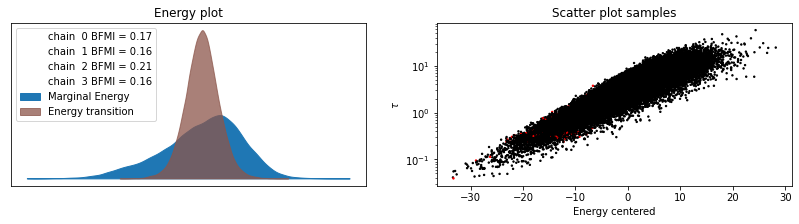

In [9]:
fig, ax = plt.subplots(1,2, figsize = (14,3))
az.plot_energy(fit_eight_schools_v0, ax = ax[0])
ax[0].set_title('Energy plot')

ax[1].scatter(samples['energy'], samples['tau'],
              color = ['k' if samples['diverging'].loc[i] == 0 else 'red' for i in range(len(samples['diverging']))], 
              s = 2)
ax[1].set_xlabel('Energy centered')
ax[1].set_ylabel(r'$\tau$')
ax[1].set_title('Scatter plot samples')
ax[1].set_yscale('log')

plt.show()

Note that the algorithm HMC was not able to fully explore the tails of the target distribution, as showed by the divergences when $\tau$ is small. Even when the step size was smaller, the exploration is incomplete. Because of that, a suggestion is to use a non-centered parametrization with indirect observation of the effects $\theta_n$. This helps with the pathological curvature of the centered distribution. The model is as follows 

$$
y_n \sim \operatorname{Normal}(\mu + \tau\tilde{\theta}_n, \sigma_n^2), 
$$

such that 

$$
\tilde{\theta}_n \sim \operatorname{Normal}(0, 1) \\
\mu \sim \operatorname{Normal}(0,10) \\
\tau \sim \operatorname{Half-C}(0,10), \\
$$

In [10]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/extra/eight_schools_v1.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/extra/eight_schools_v1.stan')
    with open('../models/extra/eight_schools_v1.pkl', 'wb') as f:
        pickle.dump(sm, f)

Compare the time to run this experiment without any problems. 

In [13]:
%%time
fit_eight_schools_v1 = sm.sampling(data=data, refresh = 0, warmup = 3000, iter = 4000)
summary = az.summary(fit_eight_schools_v1)



Gradient evaluation took 1.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 1.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 1.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 1.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.144186 seconds (Warm-up)
               0.051521 seconds (Sampling)
               0.195707 seconds (Total)


 Elapsed Time: 0.150107 seconds (Warm-up)
               0.053456 seconds (Sampling)
               0.203563 seconds (Total)


 Elapsed Time: 0.150727 seconds (Warm-up)
               0.047954 seconds (Sampling)
        

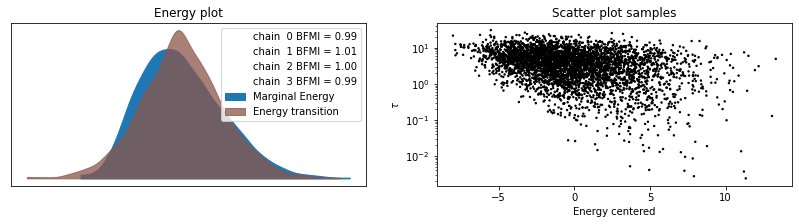

In [14]:
info = fit_eight_schools_v1.to_dataframe()

samples = {'energy': info['energy__'] - info['energy__'].mean(), 
           'tau': info['tau'], 
           'diverging': info['divergent__']}

fig, ax = plt.subplots(1,2, figsize = (14,3))
az.plot_energy(fit_eight_schools_v1, ax = ax[0])
ax[0].set_title('Energy plot')

ax[1].scatter(samples['energy'], samples['tau'],
              color = ['k' if samples['diverging'].loc[i] == 0 else 'red' for i in range(len(samples['diverging']))], 
              s = 2)
ax[1].set_xlabel('Energy centered')
ax[1].set_ylabel(r'$\tau$')
ax[1].set_title('Scatter plot samples')
ax[1].set_yscale('log')

plt.show()